<a href="https://colab.research.google.com/github/samykebaish/cs5010_data_analysis_project/blob/master/Project_Code_GL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

# Read in Data

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
df_mental = pd.read_csv(r'/content/drive/MyDrive/CS5010/MHCLD_reduced.csv') #dataset in CSV
df_poverty = pd.read_csv(r'/content/drive/MyDrive/CS5010/raw_data.csv', skiprows=2)
xls = pd.ExcelFile(r'/content/drive/MyDrive/CS5010/CS5010Project.xlsx') #excel file with codes for df_meantal
df_states_mental = pd.read_excel(xls, 'STATEFIP State Codes') #spreadsheet page with the codes for states df_mental dataframe
df_poverty_percent = pd.read_excel(xls, 'Poverty Rate by State 2018') #shows poverty percent, not totals
df_RACE = pd.read_excel(xls, 'RACE')
df_MH1 = pd.read_excel(xls,'MH1 Primary Diagnosis')
df_age_label = pd.read_excel(xls,'AGE')

### A.  Data Cleaning

In [45]:
#Adding text to key variables.  The original data is coded.
#State names
df_mental_states = df_mental.merge(df_states_mental, left_on="STATEFIP", right_on="Value") #Value and STATEFIP should be equal
df_mental_states = df_mental_states.drop(['Value'], axis=1) #remove Value column in an effort to try and keep the massive file smaller

#Diagnosis Names
df_mental_labeled = df_mental_states.merge(df_MH1, left_on="MH1", right_on="Value")
df_mental_labeled = df_mental_labeled.drop(['Value'], axis=1)

#age labels
df_mental_labeled = df_mental_labeled.merge(df_age_label, left_on="AGE", right_on="Value")
df_mental_labeled = df_mental_labeled.drop(['Value'], axis=1)
df_mental_labeled.tail()

,YEAR,AGE,RACE,MH1,STATEFIP,State,Label,Age_Range
6213786,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213787,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213788,2018,-9,-9,12,53,Washington,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213789,2018,-9,-9,12,99,Other Jurisdictions,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid
6213790,2018,-9,-9,12,99,Other Jurisdictions,Alcohol or substance use disorders,Missing/Unknown/not collected/invalid


In [46]:
#Creating a dataset that removes some of the missing values.  This are used in later analysis and analysis on the total number of cases is performed on 
#the dataframe that has not been reduced. 
#remove any unknown variables in the State column
df_states_pov = df_mental_labeled.loc[df_mental_labeled['STATEFIP'] != 99] #remove other jurisdiction from dataset to only focus on states
df_states_pov = df_states_pov.loc[df_states_pov['STATEFIP'] != 72]
df_states_pov = df_states_pov.loc[df_states_pov['AGE'] != -9]#remove Puetro Rico from dataset to focus on states 
df_states_pov.sort_values(by=['STATEFIP'])
df_states_pov.tail() #the df is sorted by STATEFIP

,YEAR,AGE,RACE,MH1,STATEFIP,State,Label,Age_Range
6209713,2018,2,3,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209714,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209715,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209716,2018,2,5,12,54,West Virginia,Alcohol or substance use disorders,12-14
6209717,2018,2,5,12,55,Wisconsin,Alcohol or substance use disorders,12-14


Quick check to ensure values were dropped properly (STATEFIP checked as proof)

In [47]:
df_states_pov.value_counts('State')

State
California              691136
Pennsylvania            565435
Ohio                    538534
Texas                   400151
Washington              289585
Minnesota               287939
Michigan                231952
Arizona                 224769
Florida                 218368
Maryland                213601
Iowa                    189343
Kentucky                157690
Colorado                150557
New Mexico              149502
Indiana                 137388
Oregon                  134743
Virginia                123094
Tennessee               117553
Alabama                 102416
Oklahoma                101830
North Carolina          101045
Connecticut              93944
South Carolina           87188
Mississippi              85449
Missouri                 76409
Arkansas                 74888
Wisconsin                71192
Illinois                 66656
Montana                  62851
New York                 57899
Utah                     56094
West Virginia            50605
Di

In [48]:
df_mental_labeled.value_counts('State')

State
California              693510
Pennsylvania            565437
Ohio                    538536
Texas                   400154
Washington              290864
Minnesota               287962
Michigan                231953
Arizona                 224773
Florida                 218368
Maryland                213605
Iowa                    189347
Kentucky                157732
Colorado                150558
New Mexico              149503
Indiana                 137388
Oregon                  134743
Virginia                123101
Tennessee               117555
Alabama                 102424
Oklahoma                101831
North Carolina          101046
Connecticut              93947
South Carolina           87192
Mississippi              85449
Missouri                 76409
Arkansas                 74888
Wisconsin                71193
Illinois                 66656
Montana                  63052
New York                 57904
Utah                     56095
West Virginia            50605
Di

### B. Exploritory Data - What is in this dataset?

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text major ticklabel objects>)

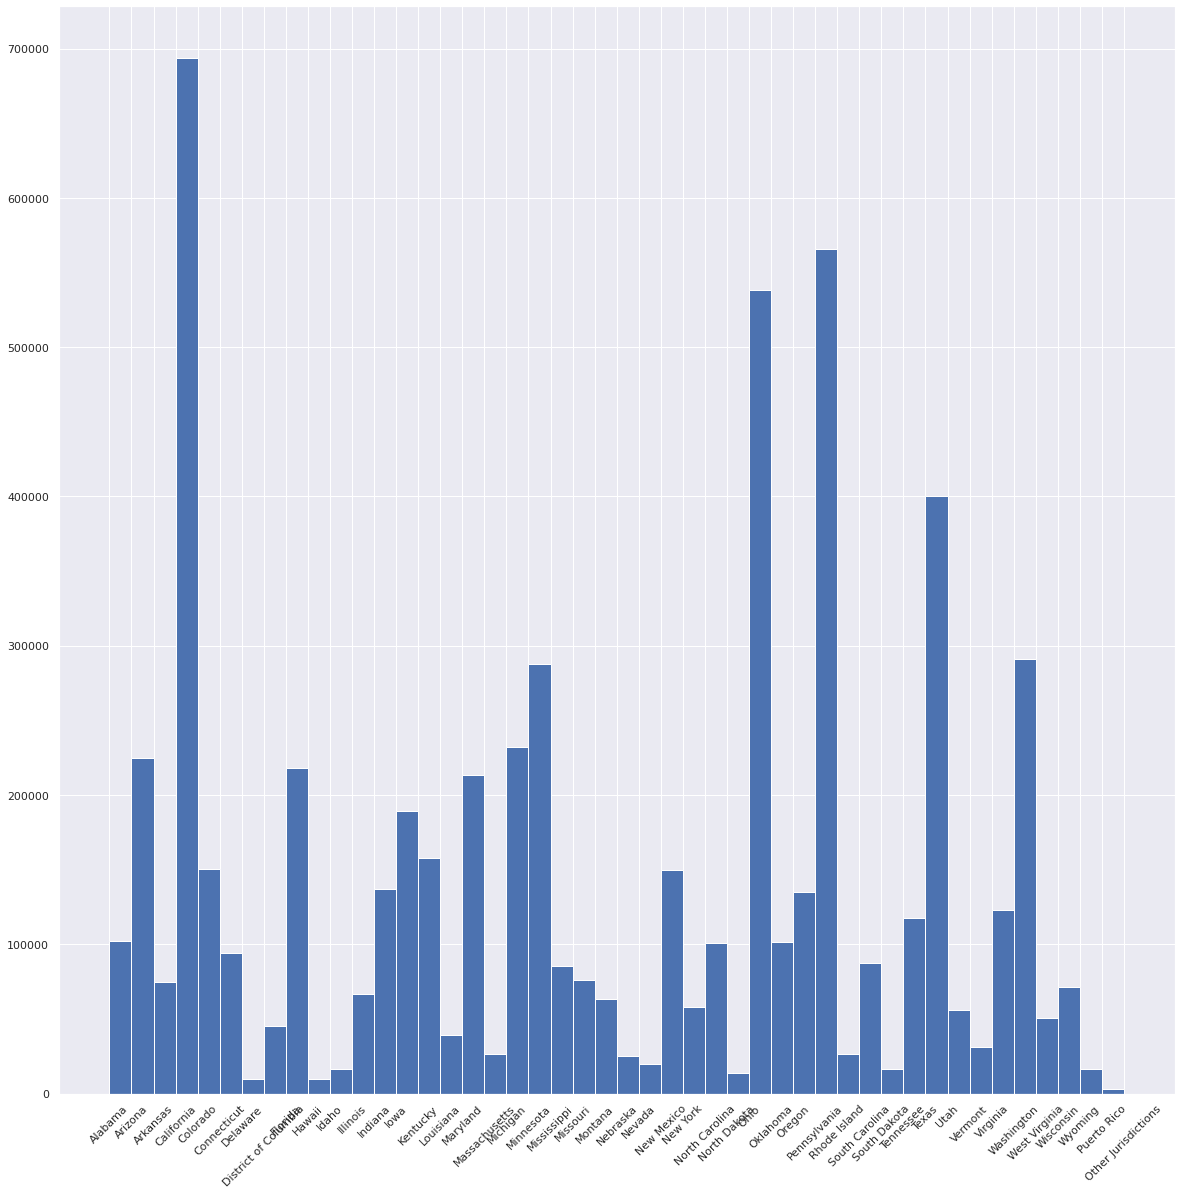

In [49]:
#Number of Cases per State
df_mental_labeled['State'].hist(bins = 46, figsize = (20,20))
plt.xticks(rotation=45)

### States with highest totals are California, Ohio, and Pennsylvania

## Age

### What is the breakdown of the ages per state?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b587444d0>,
      dtype=object)

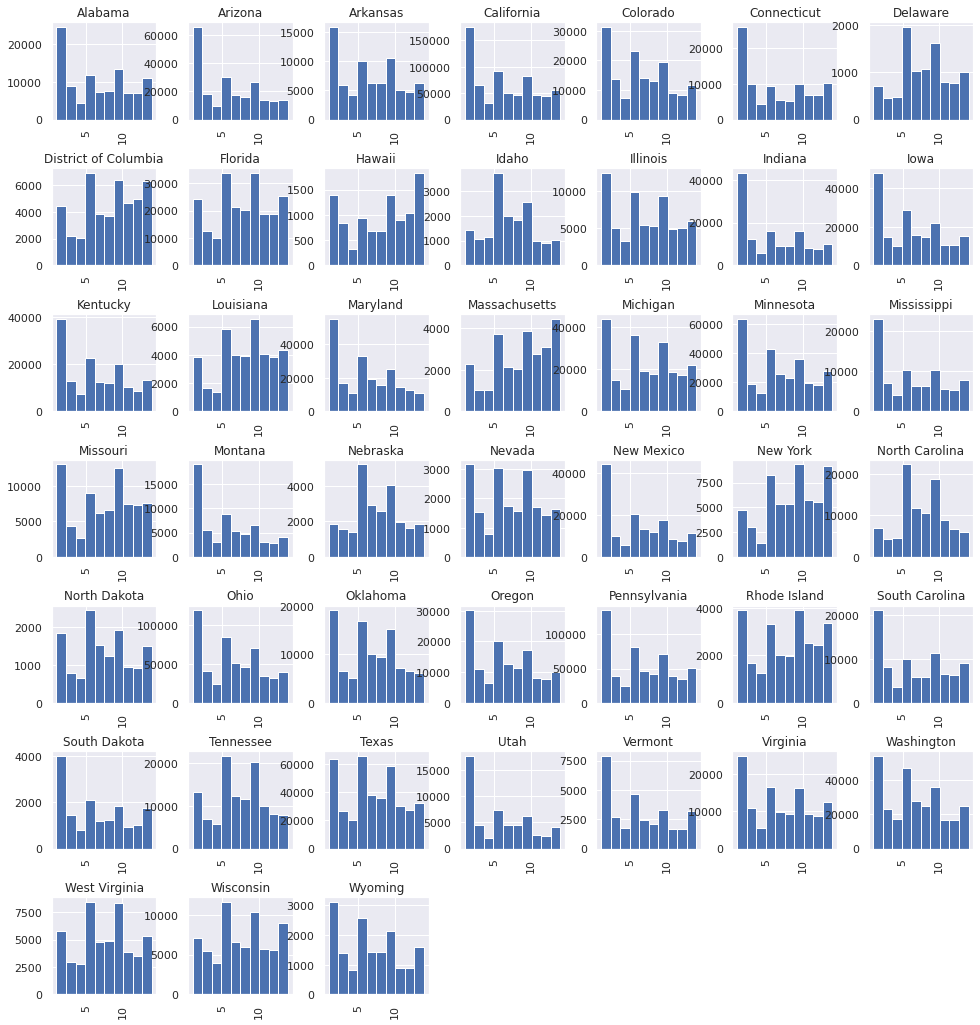

In [50]:
#using the dataset with missing age data removed. 
df_states_pov['AGE'].hist(by = df_states_pov['State'], figsize = (16,18)) # did not to the column with teh labels as this is exploratory

### The age group 1 seems to have a large number of states wtih a high total, does that hold up over all?

In [51]:
age = df_states_pov.groupby('State')['Age_Range'].value_counts().to_frame()
age = age.reset_index(0)

In [52]:
age.rename(columns={age.columns[1]: "total"}, inplace=True)
new_age = age.reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

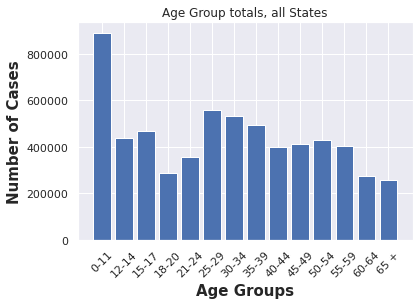

In [53]:
#totals per age group, no states
Totals_per_group = age.groupby('Age_Range')['total'].sum().to_frame().reset_index()
plt.bar(Totals_per_group['Age_Range'], Totals_per_group['total'])
plt.xlabel('Age Groups', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Cases', fontweight ='bold', fontsize = 15)
plt.title('Age Group totals, all States')
plt.xticks(rotation=45)

### Group 1 (Ages 0-11) have the highest number of cases overall.

## Primary Mental Health Diagnosis

### What is the breakdown of mental health diagnosis by Age Group?

In [54]:
#Dataset with missing data of the primary health diagnosis removed and arranged for graphing
df_mental_labeled1 = df_mental_labeled.loc[df_mental_labeled['AGE'] != -9] 
age_mh1 = df_mental_labeled1.groupby('Age_Range')['Label'].value_counts().to_frame()
age_mh1.rename(columns={age_mh1.columns[0]: 'Total_Cases' }, inplace = True)
age_mh1 = age_mh1.reset_index()

In [55]:
age_mh1 = age_mh1.rename(columns={"Label" : "Diagnosis"})
age_mh1.head()

,Age_Range,Diagnosis,Total_Cases
0,0-11,Attention deficit/hyperactivity disorder (ADD/...,232353
1,0-11,Trauma- and stressor-related disorders,227728
2,0-11,Other disorders/conditions,91534
3,0-11,Missing/Unknown,88932
4,0-11,Anxiety disorders,84127


[Text(0, 0.5, 'Age Range'), Text(0.5, 0, 'Number of Cases')]

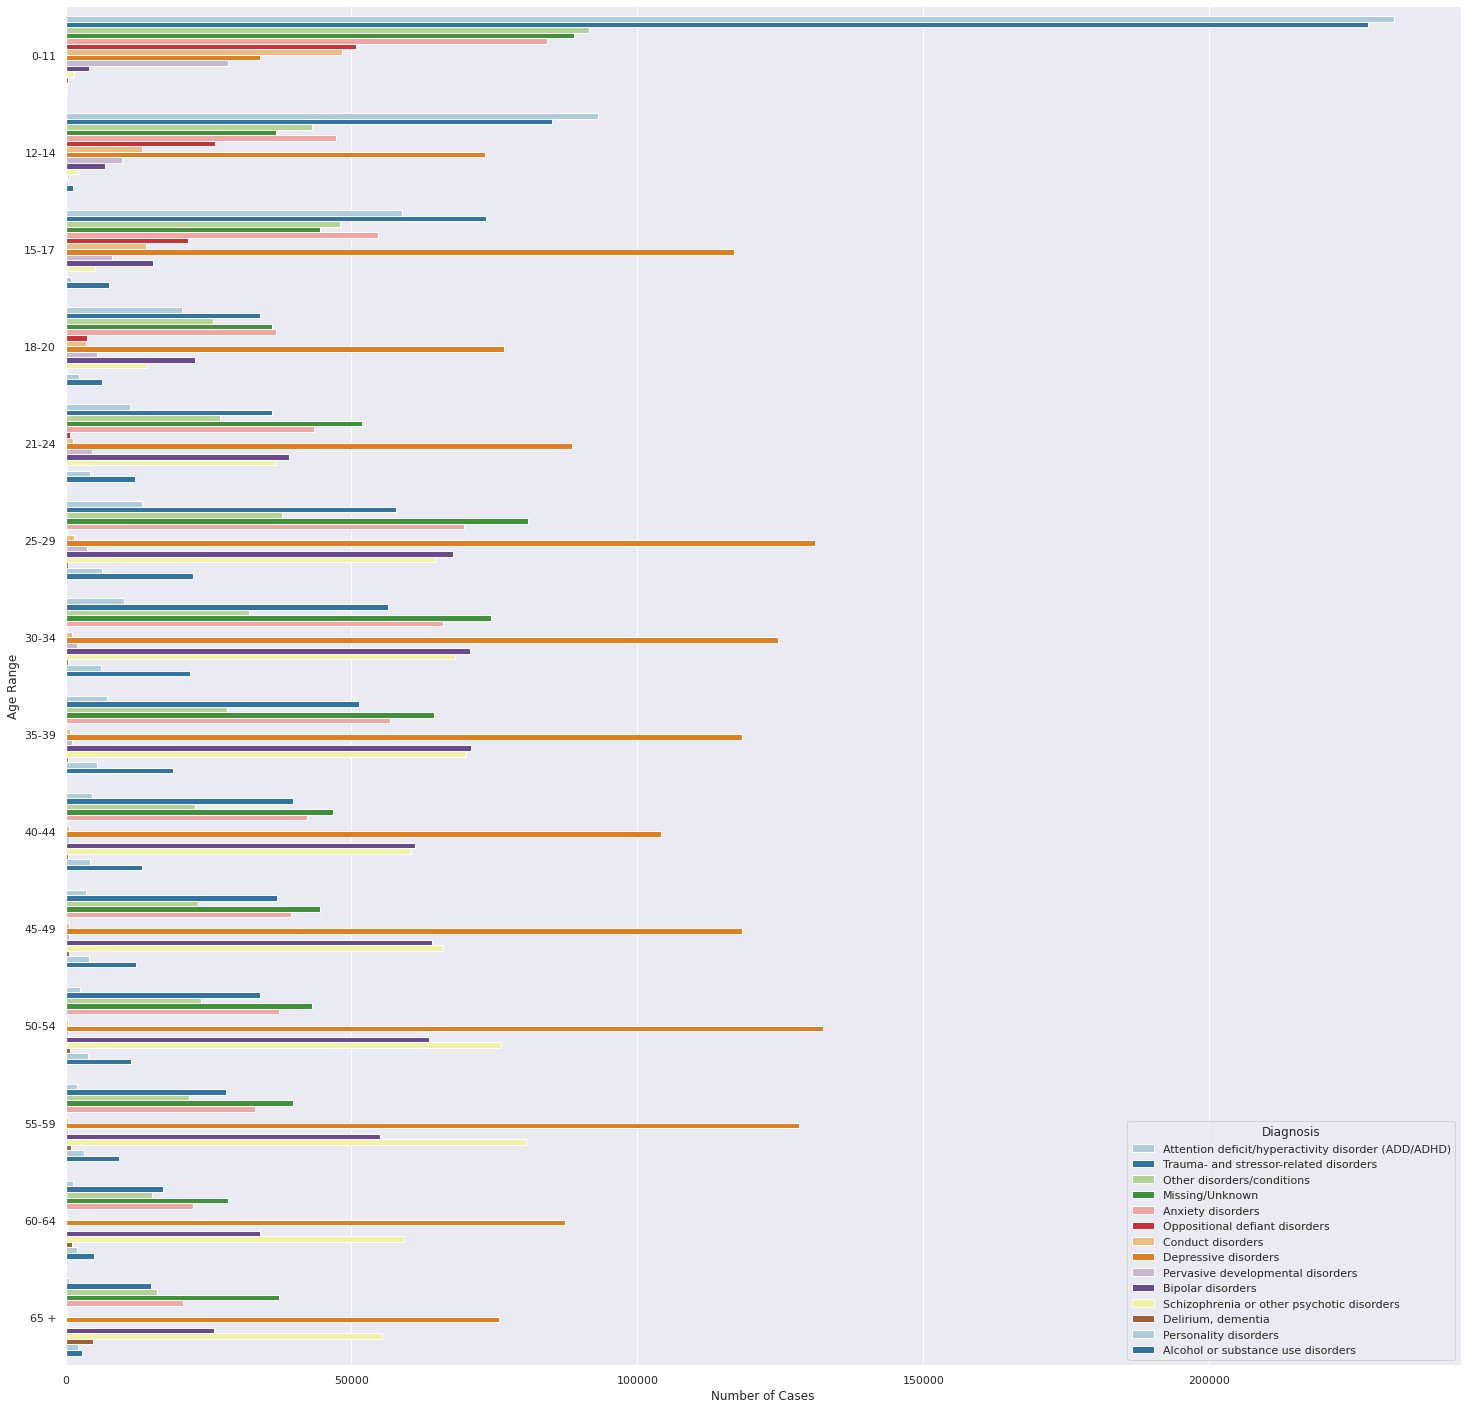

In [77]:
sns.set(rc={'figure.figsize':(25,25)})
sns.color_palette("vlag", as_cmap=True)
ax = sns.barplot(y="Age_Range", x="Total_Cases", hue="Diagnosis", data=age_mh1, palette = 'Paired')
ax.set(xlabel='Number of Cases', ylabel='Age Range')

# Poverty

## Does this data set show any correlations with the total number of cases per state/state population vs. the poverty rate for each state?


In [57]:
#clean up poverty dataset
df_poverty_edit = df_poverty[1:-8]
df_poverty_edit.head(10)

,Location,Under 100%,100-199%,200-399%,400%+,Total,Footnotes
1,Alabama,797800.0,938500.0,1479000.0,1537400.0,4752600.0,NaN
2,Alaska,76100.0,103600.0,208900.0,320500.0,709100.0,NaN
3,Arizona,973900.0,1384200.0,2196900.0,2449300.0,7004300.0,NaN
4,Arkansas,508200.0,654800.0,934300.0,824000.0,2921300.0,NaN
5,California,4940800.0,6603400.0,10648200.0,16553400.0,38745900.0,NaN
6,Colorado,541700.0,832800.0,1640000.0,2540600.0,5555200.0,NaN
7,Connecticut,358600.0,460200.0,813100.0,1834500.0,3466300.0,NaN
8,Delaware,110600.0,145400.0,268800.0,412900.0,937700.0,NaN
9,District of Columbia,111000.0,72200.0,124500.0,360200.0,667900.0,NaN
10,Florida,2791200.0,4124100.0,6709200.0,7219000.0,20843500.0,NaN


Text(0.5, 1.0, 'Poverty Total, States')

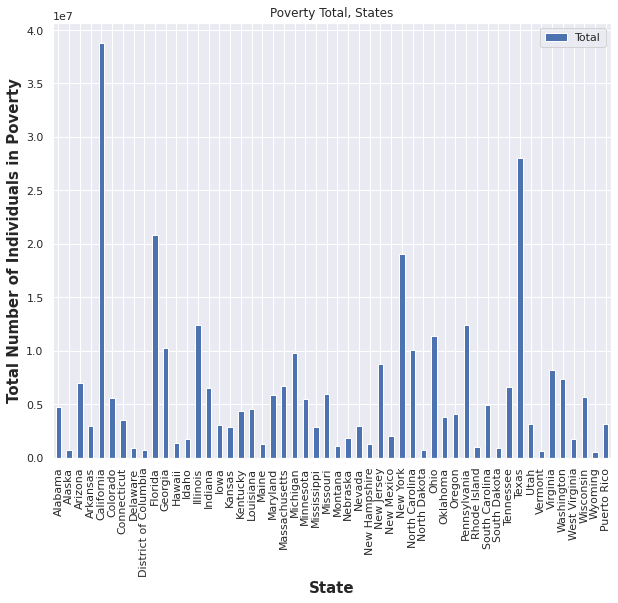

In [58]:
#poverty totals per state
df_poverty_edit.plot(x = 'Location', y = 'Total', kind = 'bar', figsize = (10,8))
plt.xlabel('State', fontweight ='bold', fontsize = 15)
plt.ylabel('Total Number of Individuals in Poverty', fontweight ='bold', fontsize = 15)
plt.title('Poverty Total, States')

In [59]:
#excel file that contains the percent poverty per state - this is dataframe clean up
df_poverty_percent1 = df_poverty_percent[2:] 
df_poverty_percent1.columns = df_poverty_percent1.iloc[0]
df_poverty_percent1 = df_poverty_percent[3:-2]
df_poverty_percent1.columns = ['State','Change in poverty rate, 2000 to 2018', 'Change 2007 to 2018', 'Change in poverty rate, 2017 to 2018', '2018 poverty rate relative to national average', 'Poverty rate 2018']
df_poverty_percent1['PovertyRate2018%'] = df_poverty_percent1['Poverty rate 2018'] * 100
df_poverty_percent1['State'] = df_poverty_percent1['State'].str.strip()
df_poverty_percent1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,State,"Change in poverty rate, 2000 to 2018",Change 2007 to 2018,"Change in poverty rate, 2017 to 2018",2018 poverty rate relative to national average,Poverty rate 2018,PovertyRate2018%
3,Alabama,0.012,-0.001,-0.001,0.037,0.168,16.8
4,Alaska,0.018,0.02,-0.002,-0.022,0.109,10.9
5,Arizona,-0.016,-0.002,-0.009,0.009,0.14,14
6,Arkansas,0.002,-0.007,0.008,0.041,0.172,17.2
7,California,-0.009,0.004,-0.005,-0.003,0.128,12.8


In [60]:
#found that the column had extra spaces at the end of the column 
df_poverty_percent1.info()
print(df_poverty_percent1['State'][3] + ',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 3 to 53
Data columns (total 7 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   State                                           51 non-null     object
 1   Change in poverty rate, 2000 to 2018            51 non-null     object
 2   Change 2007 to 2018                             51 non-null     object
 3   Change in poverty rate, 2017 to 2018            51 non-null     object
 4   2018 poverty rate relative to national average  51 non-null     object
 5   Poverty rate 2018                               51 non-null     object
 6   PovertyRate2018%                                51 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB
Alabama,


In [61]:
#all toatls of each column per state
df_state_totals = df_mental_labeled.groupby(['State']).count()['AGE'].to_frame().reset_index()
df_state_totals.rename(columns={df_state_totals.columns[1]: "total_cases"}, inplace=True)
df_state_totals.head()

,State,total_cases
0,Alabama,102424
1,Arizona,224773
2,Arkansas,74888
3,California,693510
4,Colorado,150558


In [62]:
#added the total mental health cases per state
poverty_mental_totals = df_poverty_percent1.merge(df_state_totals, on="State")
poverty_mental_totals.head()

,State,"Change in poverty rate, 2000 to 2018",Change 2007 to 2018,"Change in poverty rate, 2017 to 2018",2018 poverty rate relative to national average,Poverty rate 2018,PovertyRate2018%,total_cases
0,Alabama,0.012,-0.001,-0.001,0.037,0.168,16.8,102424
1,Arizona,-0.016,-0.002,-0.009,0.009,0.14,14,224773
2,Arkansas,0.002,-0.007,0.008,0.041,0.172,17.2,74888
3,California,-0.009,0.004,-0.005,-0.003,0.128,12.8,693510
4,Colorado,0.009,-0.024,-0.007,-0.035,0.096,9.6,150558


Text(0.5, 1.0, 'Total Mental Health Cases per State vs. Poverty Rate %')

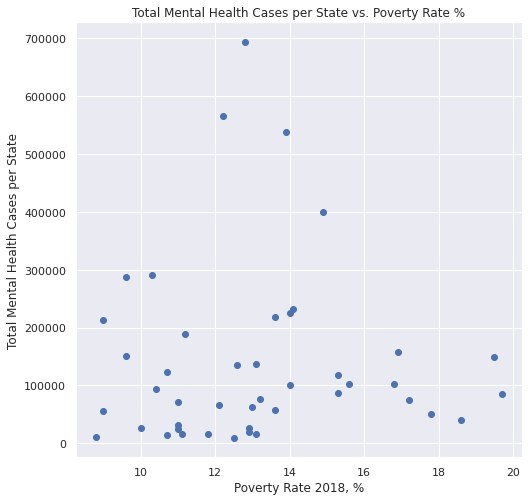

In [63]:
#No obvious correlation when use total number of cases
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = 'PovertyRate2018%', y = 'total_cases', data = poverty_mental_totals)
plt.xlabel('Poverty Rate 2018, %')
plt.ylabel('Total Mental Health Cases per State')
plt.title('Total Mental Health Cases per State vs. Poverty Rate %')


In [64]:
#now taking the total number of cases and dividing by popluation to check correlation

#https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html data source
state_pop = pd.read_excel(r'/content/drive/MyDrive/CS5010/nst-est2019-01.xlsx')
#df_state_pop = pd.read_excel(xls, 'STATEFIP State Codes')
state_pop.head()
state_pop.columns = state_pop.iloc[2]
state_pop.rename(columns={state_pop.columns[0]: "State"}, inplace=True)
state_pop=state_pop[8:]
state_pop['State'] = state_pop['State'].str.replace('.','', regex = True) #remove extra . to merge

#state_pop.columns.map(type) #had to check what the column types were, wasn't able to access columns decided to map to string
state_pop.columns =state_pop.columns.map(str)
state_pop.head()

2,State,Census,Estimates Base,2010,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
8,Alabama,4779736,4780125,4785437,4799069.0,4815588.0,4830081.0,4841799.0,4852347.0,4863525.0,4874486.0,4887681.0,4903185.0
9,Alaska,710231,710249,713910,722128.0,730443.0,737068.0,736283.0,737498.0,741456.0,739700.0,735139.0,731545.0
10,Arizona,6392017,6392288,6407172,6472643.0,6554978.0,6632764.0,6730413.0,6829676.0,6941072.0,7044008.0,7158024.0,7278717.0
11,Arkansas,2915918,2916031,2921964,2940667.0,2952164.0,2959400.0,2967392.0,2978048.0,2989918.0,3001345.0,3009733.0,3017804.0
12,California,37253956,37254519,37319502,37638369.0,37948800.0,38260787.0,38596972.0,38918045.0,39167117.0,39358497.0,39461588.0,39512223.0


In [65]:
#merge state population to main dataframe for analysis
pd.options.mode.chained_assignment = None  # default='warn' 
poverty_mental_pop = poverty_mental_totals.merge(state_pop, on="State")
poverty_mental_pop_reduced = poverty_mental_pop[['State', 'PovertyRate2018%', 'total_cases', '2018.0']]
poverty_mental_pop_reduced.rename(columns={poverty_mental_pop_reduced.columns[3]: "2018 population"}, inplace=True)
poverty_mental_pop_reduced['cases/pop'] = poverty_mental_pop_reduced['total_cases']/poverty_mental_pop_reduced['2018 population']
poverty_mental_pop_reduced['PovertyRate2018%'] = poverty_mental_pop_reduced['PovertyRate2018%'].astype(float)
poverty_mental_pop_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             44 non-null     object 
 1   PovertyRate2018%  44 non-null     float64
 2   total_cases       44 non-null     int64  
 3   2018 population   44 non-null     float64
 4   cases/pop         44 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


Text(0.5, 1.0, 'Total Mental Health Cases per State Population vs. Poverty Rate %')

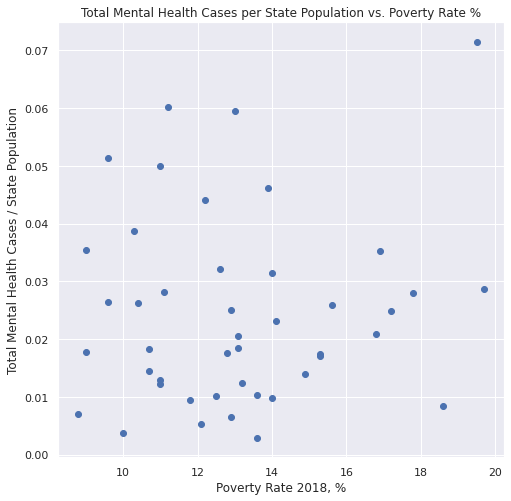

In [66]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = 'PovertyRate2018%', y = 'cases/pop', data = poverty_mental_pop_reduced)
plt.xlabel('Poverty Rate 2018, %')
plt.ylabel('Total Mental Health Cases / State Population')
plt.title('Total Mental Health Cases per State Population vs. Poverty Rate %')

#results - no real correlation between the mental health cases and poulation

# Statistical Analysis

## Simple Linear Regression 

In [67]:
#run SLR to ensure scatter plot results are accurate - There is no predictive abillity in this
x = poverty_mental_pop_reduced['PovertyRate2018%']
x = sm.add_constant(x) #constant is not added by default and must be added
case_model =sm.OLS(poverty_mental_pop_reduced['cases/pop'], x).fit()
print(case_model.summary())

                            OLS Regression Results                            
Dep. Variable:              cases/pop   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4022
Date:                Thu, 06 May 2021   Prob (F-statistic):              0.529
Time:                        17:10:05   Log-Likelihood:                 119.35
No. Observations:                  44   AIC:                            -234.7
Df Residuals:                      42   BIC:                            -231.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0172      0.012  

### Visualization of regression model

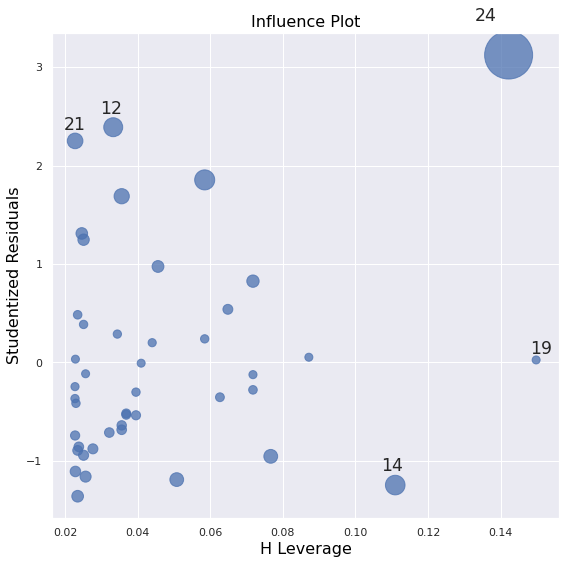

In [68]:
#Leverage plot of model to see outliers - there are outliers
plt.rcParams["figure.figsize"] = (8,8)
fig = sm.graphics.influence_plot(case_model, criterion="cooks")
fig.tight_layout(pad=1.0)

## This graph represents the external studentized residuals to check for outliers, from this plot, there are 4.

In [69]:
X = poverty_mental_pop_reduced.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = poverty_mental_pop_reduced.iloc[:, 4].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

## Plot for first attempt at linear regression

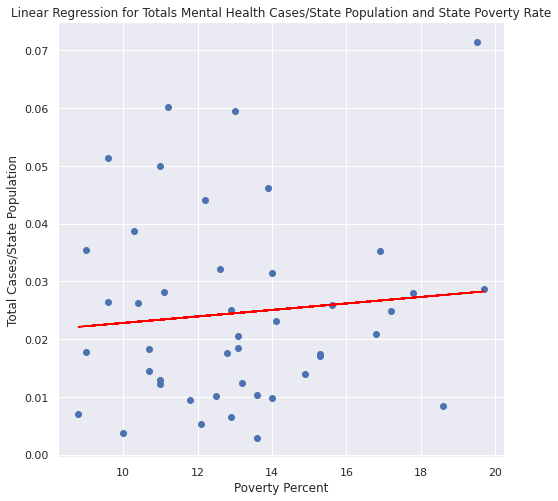

In [70]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Poverty Percent')
plt.ylabel('Total Cases/State Population')
plt.title('Linear Regression for Totals Mental Health Cases/State Population and State Poverty Rate')
plt.show()

## Model is showing little relationship between the varibles, check residuals

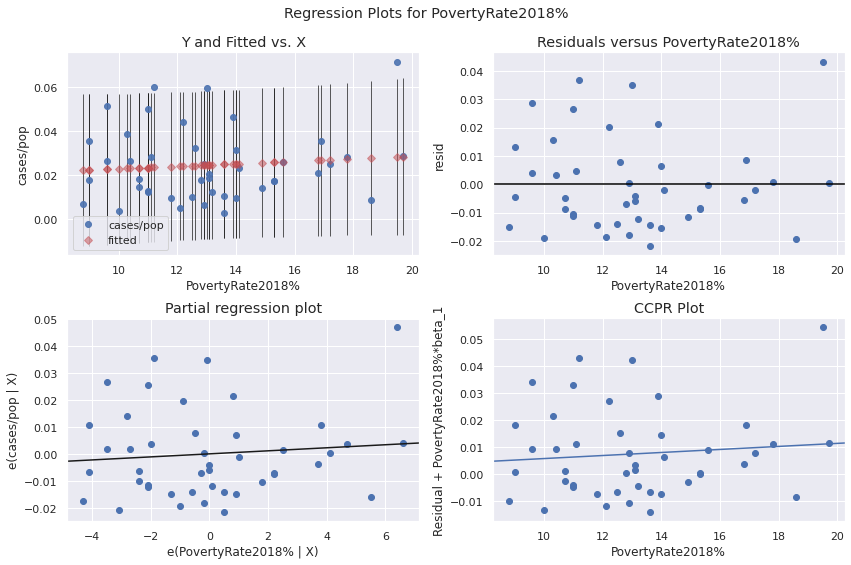

In [71]:
#trying to look at residuals - a bit skewed

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(case_model, 'PovertyRate2018%', fig=fig)

##  The outliers above may be contributing to the all positive residuals, let's remove them to see how the model responds. 

In [72]:
poverty_mental_pop_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             44 non-null     object 
 1   PovertyRate2018%  44 non-null     float64
 2   total_cases       44 non-null     int64  
 3   2018 population   44 non-null     float64
 4   cases/pop         44 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


In [73]:
no_out_pov= poverty_mental_pop_reduced.drop([poverty_mental_pop_reduced.index[21] , poverty_mental_pop_reduced.index[12], poverty_mental_pop_reduced.index[14], 
                                             poverty_mental_pop_reduced.index[19], poverty_mental_pop_reduced.index[24]])
no_out_pov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 43
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State             39 non-null     object 
 1   PovertyRate2018%  39 non-null     float64
 2   total_cases       39 non-null     int64  
 3   2018 population   39 non-null     float64
 4   cases/pop         39 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.8+ KB


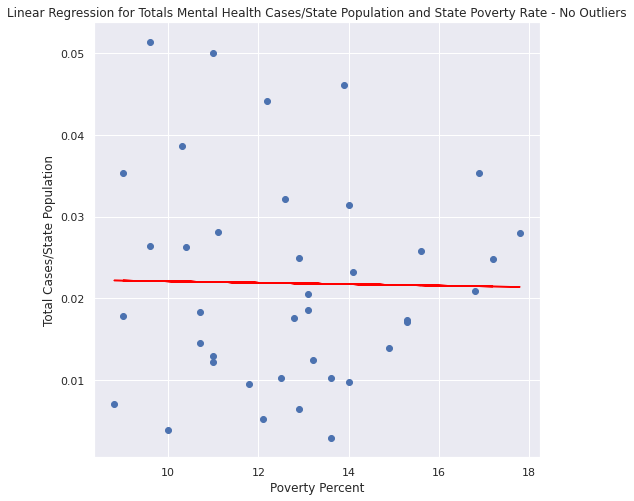

In [74]:
X1 = no_out_pov.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y1 = no_out_pov.iloc[:, 4].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X1, Y1)  # perform linear regression
Y1_pred = linear_regressor.predict(X1)  # make predictions
plt.scatter(X1, Y1)
plt.plot(X1, Y1_pred, color='red')
plt.xlabel('Poverty Percent')
plt.ylabel('Total Cases/State Population')
plt.title('Linear Regression for Totals Mental Health Cases/State Population and State Poverty Rate - No Outliers')
plt.show()

In [75]:
#run SLR to ensure scatter plot results are accurate - There is no predictive abillity in this
x = no_out_pov['PovertyRate2018%']
x = sm.add_constant(x) #constant is not added by default and must be added
case_model1 =sm.OLS(no_out_pov['cases/pop'], x).fit()
print(case_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              cases/pop   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                  0.009979
Date:                Thu, 06 May 2021   Prob (F-statistic):              0.921
Time:                        17:10:08   Log-Likelihood:                 115.18
No. Observations:                  39   AIC:                            -226.4
Df Residuals:                      37   BIC:                            -223.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0230      0.011  

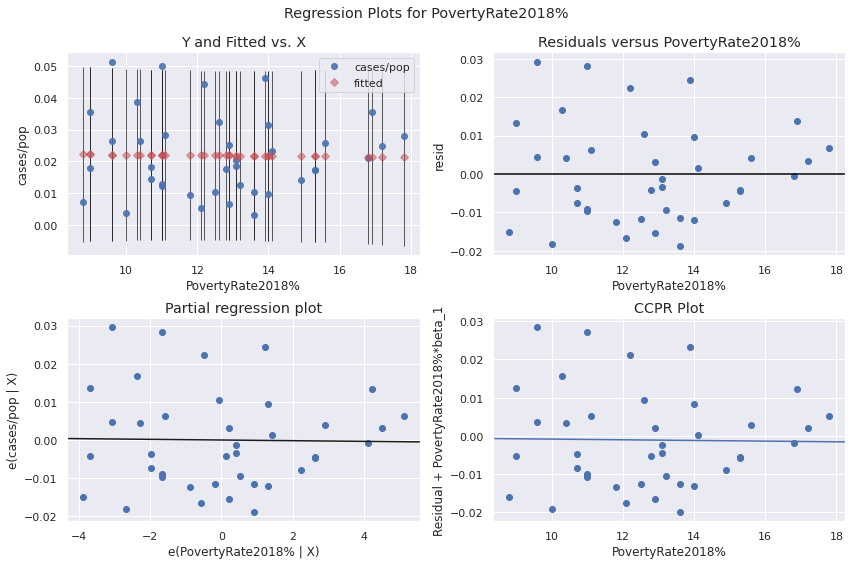

In [78]:
#trying to look at residuals - 
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(case_model1, 'PovertyRate2018%', fig=fig)

### The residuals look better, but the model still has no predictive abillites.  The scatter of the points is a high indicator this is the case. 